# Initial settings

In [2]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

#Libraries
import yaml
import math
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torchvision.transforms import (
    Compose,
    Resize,
    CenterCrop,
    RandomHorizontalFlip,
    ToTensor,
    Normalize,
    InterpolationMode,
)
import wandb
import datasets, diffusers
from datasets import load_dataset
from diffusers import UNet2DModel, DDPMScheduler
from diffusers import DDPMPipeline
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version
import logging
from accelerate.logging import get_logger
from accelerate import Accelerator

import torchvision

# MAIN

In [25]:
selected_gpu = 0 #select the GPU to use
device = torch.device("cuda:" + str(selected_gpu) if torch.cuda.is_available() else "cpu")
print(f'The device is: {device}\n')

# load the config file
with open('config.yaml') as file: # expects the config file to be in the same directory
    config = yaml.load(file, Loader=yaml.FullLoader)
    
# define logging directory
pipeline_dir = repo_path / config['saving']['local']['outputs_dir'] / config['saving']['local']['pipeline_name']
logging_dir = pipeline_dir / config['logging']['dir_name']

# start the accelerator
accelerator = Accelerator(
    gradient_accumulation_steps=config['training']['gradient_accumulation']['steps'],
    mixed_precision=config['training']['mixed_precision']['type'],
    log_with= config['logging']['logger_name'],
    logging_dir= logging_dir,
)

# show the accelerator state as first log message
print(accelerator.state)

data_dir = repo_path / config['processing']['dataset']
# load from local directory
dataset = load_dataset("imagefolder", data_dir=data_dir, name='breast10p', split='train')

preprocess = Compose(
    [
        Resize(config['processing']['resolution'], interpolation= InterpolationMode.BILINEAR), #getattr(InterpolationMode, config['processing']['interpolation'])),  # Smaller edge is resized to 256 preserving aspect ratio
        CenterCrop(config['processing']['resolution']),  # Center crop to the desired squared resolution
        RandomHorizontalFlip(),  # Horizontal randomly flip (data augmentation)
        ToTensor(),  # Convert to tensor (0, 1)
        Normalize([0.5], [0.5]),  # Map to (-1, 1) as a way to make data more similar to a Gaussian distribution
    ]
)
def transform(batch_dict):
    """Transform the images in the dataset to the desired format, this generates a dictionary with the key "images" containing the images in a list.
    It should include a formatting function as preproces. A formatting function is a callable that takes a batch as (dict) and returns a batch also as (dict).
    The formatting function is defined outside of the function (not self-contained)

    Args:
        batch_dict (dict): dictionary containing the images in a list under the key "image"

    Returns:
        dict: dictionary containing the images in a list under the key "images"
    """
    images = [preprocess(image.convert(mode='F')) for image in batch_dict["image"]]
    return {"images": images}
#set the transform function to the dataset
dataset.set_transform(transform)

# Create the dataloader
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=config['processing']['batch_size'], num_workers= config['processing']['num_workers'], shuffle=True
)

The device is: cuda:0

Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda
Mixed precision type: no



Resolving data files:   0%|          | 0/4059 [00:00<?, ?it/s]

Using custom data configuration breast10p-2e62d20811b22628
Found cached dataset imagefolder (/home/ricardo/.cache/huggingface/datasets/imagefolder/breast10p-2e62d20811b22628/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


In [26]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]

In [29]:
len(xb.unique())

14220

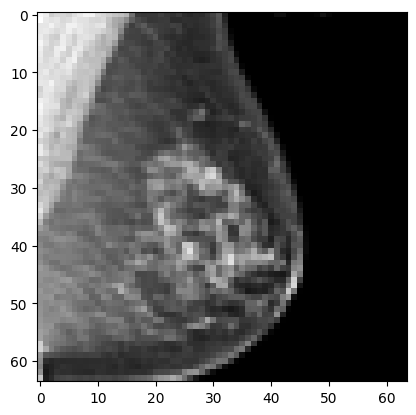

In [34]:
example = xb[0,0].cpu().numpy()
# plot the example
import matplotlib.pyplot as plt
plt.imshow(example, cmap='gray')

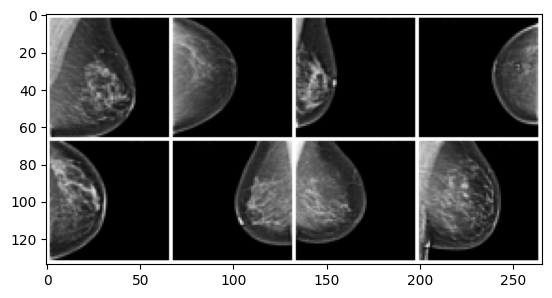

In [45]:
#x = xb * 0.5 + 0.5
x = xb
grid = torchvision.utils.make_grid(x, nrow=4, normalize=True, pad_value=1)
grid_im = grid.detach().cpu().permute(1, 2, 0)
plt.imshow(grid_im, cmap='gray')

In [16]:
def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1)
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint16))
    return grid_im

Resolving data files:   0%|          | 0/4059 [00:00<?, ?it/s]

Using custom data configuration breast10p-2e62d20811b22628
Found cached dataset imagefolder (/home/ricardo/.cache/huggingface/datasets/imagefolder/breast10p-2e62d20811b22628/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]